# SubMax Processing

**Instructions**

* Extract the 40 strokes whose peak speed values are closest to the median speed within each of the following speed ranges:
   * 60% vMxS (1–60 s)
   * 70% vMxS (61–120 s)
   * 80% vMxS (121–180 s)
* The start of the test (0s) is defined as the point when the speed exceeds 0.1 km/h and subsequently increases continuously.

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

# used to make plots
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/Users/katieli/Research/wheelchair/data/raw/SubMax/HYB/ALP_submax_HYB.csv")

In [3]:
df.describe()

,time[sec],cycle[count],acc_x_R[m/s2],acc_y_R[m/s2],gyro_z_R[rad/s],force_x_R[N],force_y_R[N],force_z_R[N],moment_x_R[Nm],moment_y_R[Nm],...,moment_y_L[Nm],moment_z_L[Nm],speed_L[km/h],distance_L[km],theta_cop_L[deg],tangential_force_L[N],radial_force_L[N],axle_force_L[N],phi_cop_L[deg],m_copz_L[Nm]
count,81491.000000,81491.000000,81491.000000,81491.000000,81491.000000,81491.000000,81491.000000,81491.000000,81491.000000,81491.000000,...,81491.000000,81491.000000,81491.000000,81491.000000,14066.000000,14066.000000,14066.000000,81491.000000,14066.000000,14066.000000
mean,101.862500,103.602668,1.027685,0.014568,-21.053568,0.903995,-1.024366,13.582015,-0.235400,-0.061079,...,-0.015771,-1.910244,25.113271,0.637568,108.967755,81.761780,60.841487,15.158937,25.306088,0.524094
std,58.811424,66.505317,7.379572,7.463640,5.777643,42.512173,42.766762,34.706434,4.667405,4.452004,...,4.738114,5.588656,6.901496,0.435290,55.922875,57.379559,68.268109,38.058129,33.092271,3.018623
min,0.000000,0.000000,-38.389407,-37.737040,-26.837362,-345.665264,-331.328759,-80.444246,-32.761869,-32.117968,...,-28.674169,-40.747369,-0.086623,-0.000114,0.802752,-72.725483,-253.299629,-62.556278,-83.151420,-18.454908
25%,50.931250,45.000000,-5.028576,-5.938960,-25.294251,-3.146851,-2.904747,-0.599336,-0.326928,-0.170728,...,-0.140832,-0.231317,23.191982,0.252271,56.891142,25.653856,1.116751,-0.780328,1.069496,-1.528171
50%,101.862500,104.000000,1.534704,0.034160,-22.391073,-0.711029,-0.320224,0.466151,-0.078261,0.019933,...,0.035155,-0.053381,26.702753,0.609790,103.973413,90.469005,64.927297,0.260110,36.798765,0.252612
75%,152.793750,162.000000,7.510321,6.246400,-19.447456,1.629889,1.597469,2.130974,0.120999,0.230081,...,0.220441,0.071174,30.182952,1.010959,159.385806,131.063502,110.314251,1.950820,52.939876,2.489158
max,203.725000,211.000000,40.054725,30.787920,0.038312,335.074543,325.685009,227.414818,31.743103,31.398994,...,33.469886,8.638798,32.345974,1.421184,359.159839,233.241351,276.555082,228.896153,74.803396,14.967823


In [4]:
df['power_z[W]'] = df['gyro_z_R[rad/s]']*df['moment_z_R[Nm]']

In [5]:
df["moment_z_R[Nm]"]

0        0.004524
1       -0.004524
2        0.018095
3        0.022618
4        0.022618
           ...   
81486   -0.094997
81487    0.049760
81488    0.113092
81489    0.000000
81490   -0.004524
Name: moment_z_R[Nm], Length: 81491, dtype: float64

## Find the most similar cycles in a given window

In [6]:
# NOTE: generated with CLAUDE - not reviewed at all yet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy.spatial.distance import cdist


# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

def time_normalize_cycle(cycle_data, time_col='time', moment_col='propulsion_moment', n_points=101):
    """Time-normalize a single cycle to 0-100%"""
    time = cycle_data[time_col].values
    moment = cycle_data[moment_col].values
    
    time_pct = np.linspace(0, 100, len(moment))
    time_norm = np.linspace(0, 100, n_points)
    
    f = interpolate.interp1d(time_pct, moment, kind='cubic', fill_value='extrapolate')
    moment_norm = f(time_norm)
    
    return moment_norm

def find_steady_state_cycles(df, cycle_col='cycle_id', time_col='time',
                             moment_col='propulsion_moment', n_select=40):
    """
    Find the n_select most similar cycles (steady-state propulsion)
    Excludes acceleration/deceleration cycles with anomalous torque patterns

    For this project, we want to select 40 of them per the 60-second periods
    """
    
    cycle_ids = df[cycle_col].unique()
    n_cycles = len(cycle_ids)
    
    print(f"Analyzing {n_cycles} cycles...")
    
    # Time-normalize all cycles to compare shapes
    normalized_cycles = []
    for cycle_id in cycle_ids:
        cycle_data = df[df[cycle_col] == cycle_id]
        norm_cycle = time_normalize_cycle(cycle_data, time_col, moment_col)
        normalized_cycles.append(norm_cycle)
    
    cycle_matrix = np.array(normalized_cycles)  # (n_cycles, 101)
    
    # Calculate pairwise RMSD between all cycles
    distances = cdist(cycle_matrix, cycle_matrix, metric='euclidean')
    
    # Find the n_select cycles with minimum average distance to each other
    mean_distances = distances.mean(axis=1)
    
    # Select cycles with lowest mean distance (most similar to others)
    steady_state_idx = np.argsort(mean_distances)[:n_select]
    selected_cycle_ids = cycle_ids[steady_state_idx]
    
    # Statistics for the selected steady-state cycles
    selected_cycles = cycle_matrix[steady_state_idx]
    mean_curve = selected_cycles.mean(axis=0)
    std_curve = selected_cycles.std(axis=0)
    
    # Calculate within-cluster consistency
    selected_distances = distances[steady_state_idx][:, steady_state_idx]
    mean_internal_distance = selected_distances[np.triu_indices_from(selected_distances, k=1)].mean()
    
    print(f"Selected {n_select} steady-state cycles")
    print(f"Mean internal RMSD: {mean_internal_distance:.2f}")
    print(f"Excluded {n_cycles - n_select} cycles (likely acceleration/deceleration)")
    
    results = {
        'selected_cycle_ids': selected_cycle_ids,
        'excluded_cycle_ids': np.setdiff1d(cycle_ids, selected_cycle_ids),
        'mean_curve': mean_curve,
        'std_curve': std_curve,
        'mean_internal_rmsd': mean_internal_distance,
        'all_mean_distances': mean_distances,
        'selected_cycles_matrix': selected_cycles,
        'all_cycles_matrix': cycle_matrix,
        'all_cycle_ids': cycle_ids,
        'selected_idx': steady_state_idx
    }
    
    return results

def plot_cycle_selection_analysis(df, results, time_col='time', 
                                  moment_col='propulsion_moment', cycle_col='cycle_id'):
    """
    Comprehensive visualization of cycle selection results
    """
    
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Distance distribution - which cycles were selected?
    ax1 = plt.subplot(3, 3, 1)
    distances = results['all_mean_distances']
    selected_idx = results['selected_idx']
    
    ax1.hist(distances, bins=30, alpha=0.6, label='All cycles', color='gray')
    ax1.hist(distances[selected_idx], bins=30, alpha=0.8, label='Selected cycles', color='green')
    ax1.axvline(distances[selected_idx].max(), color='red', linestyle='--', 
                label=f'Selection threshold')
    ax1.set_xlabel('Mean RMSD to all other cycles')
    ax1.set_ylabel('Count')
    ax1.set_title('Cycle Selection Based on Similarity')
    ax1.legend()
    
    # 2. All cycles overlaid (gray) with selected cycles highlighted
    ax2 = plt.subplot(3, 3, 2)
    time_norm = np.linspace(0, 100, 101)
    
    # Plot all cycles in gray
    for i, cycle in enumerate(results['all_cycles_matrix']):
        if i not in selected_idx:
            ax2.plot(time_norm, cycle, color='lightgray', alpha=0.3, linewidth=0.5)
    
    # Plot selected cycles in color
    for cycle in results['selected_cycles_matrix']:
        ax2.plot(time_norm, cycle, color='steelblue', alpha=0.3, linewidth=1)
    
    # Plot mean ± SD
    mean_curve = results['mean_curve']
    std_curve = results['std_curve']
    ax2.plot(time_norm, mean_curve, 'r-', linewidth=2.5, label='Mean (selected)')
    ax2.fill_between(time_norm, mean_curve - std_curve, mean_curve + std_curve, 
                     alpha=0.3, color='red', label='±1 SD')
    
    ax2.set_xlabel('Cycle (%)')
    ax2.set_ylabel('Propulsion Moment')
    ax2.set_title('Selected vs Excluded Cycles')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Mean ± SD only (cleaner view)
    ax3 = plt.subplot(3, 3, 3)
    ax3.plot(time_norm, mean_curve, 'b-', linewidth=2.5, label='Mean')
    ax3.fill_between(time_norm, mean_curve - std_curve, mean_curve + std_curve, 
                     alpha=0.4, color='blue', label='±1 SD')
    ax3.fill_between(time_norm, mean_curve - 2*std_curve, mean_curve + 2*std_curve, 
                     alpha=0.2, color='blue', label='±2 SD')
    ax3.set_xlabel('Cycle (%)')
    ax3.set_ylabel('Propulsion Moment')
    ax3.set_title('Mean Steady-State Pattern')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Coefficient of variation across cycle
    ax4 = plt.subplot(3, 3, 4)
    cv = (std_curve / np.abs(mean_curve)) * 100
    ax4.plot(time_norm, cv, 'purple', linewidth=2)
    ax4.axhline(cv.mean(), color='red', linestyle='--', label=f'Mean CV: {cv.mean():.1f}%')
    ax4.set_xlabel('Cycle (%)')
    ax4.set_ylabel('Coefficient of Variation (%)')
    ax4.set_title('Variability Across Cycle Phase')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Time series view - original data with selected cycles highlighted
    ax5 = plt.subplot(3, 3, 5)
    ax5.plot(df[time_col], df[moment_col], 'gray', alpha=0.5, linewidth=0.5, label='All data')
    
    selected_df = df[df[cycle_col].isin(results['selected_cycle_ids'])]
    ax5.plot(selected_df[time_col], selected_df[moment_col], 'blue', 
             alpha=0.7, linewidth=1, label='Selected cycles')
    
    ax5.set_xlabel('Time (s)')
    ax5.set_ylabel('Propulsion Moment')
    ax5.set_title('Time Series: Selected vs All Cycles')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Peak moment comparison
    ax6 = plt.subplot(3, 3, 6)
    all_peaks = results['all_cycles_matrix'].max(axis=1)
    selected_peaks = results['selected_cycles_matrix'].max(axis=1)
    excluded_peaks = np.delete(all_peaks, selected_idx)
    
    data_to_plot = [selected_peaks, excluded_peaks]
    positions = [1, 2]
    bp = ax6.boxplot(data_to_plot, positions=positions, widths=0.6, patch_artist=True,
                     labels=['Selected', 'Excluded'])
    bp['boxes'][0].set_facecolor('green')
    bp['boxes'][0].set_alpha(0.6)
    bp['boxes'][1].set_facecolor('red')
    bp['boxes'][1].set_alpha(0.6)
    
    ax6.set_ylabel('Peak Propulsion Moment')
    ax6.set_title('Peak Moment: Selected vs Excluded')
    ax6.grid(True, alpha=0.3, axis='y')
    
    # 7. Cycle-by-cycle distance plot
    ax7 = plt.subplot(3, 3, 7)
    cycle_nums = np.arange(len(results['all_cycle_ids']))
    colors = ['green' if i in selected_idx else 'red' for i in range(len(distances))]
    ax7.scatter(cycle_nums, distances, c=colors, alpha=0.6, s=50)
    ax7.axhline(distances[selected_idx].max(), color='black', linestyle='--', 
                linewidth=1, label='Selection threshold')
    ax7.set_xlabel('Cycle Number')
    ax7.set_ylabel('Mean RMSD')
    ax7.set_title('Similarity Score by Cycle')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # 8. Heatmap of pairwise distances (subset)
    ax8 = plt.subplot(3, 3, 8)
    # Show distances for selected cycles only
    selected_distances = cdist(results['selected_cycles_matrix'], 
                               results['selected_cycles_matrix'], 
                               metric='euclidean')
    
    im = ax8.imshow(selected_distances, cmap='viridis', aspect='auto')
    ax8.set_xlabel('Cycle Index (selected)')
    ax8.set_ylabel('Cycle Index (selected)')
    ax8.set_title('Pairwise Distances\n(Selected Cycles Only)')
    plt.colorbar(im, ax=ax8, label='RMSD')
    
    # 9. Summary statistics text
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')
    
    summary_text = f"""
    SUMMARY STATISTICS
    
    Total cycles detected: {len(results['all_cycle_ids'])}
    Selected cycles: {len(results['selected_cycle_ids'])}
    Excluded cycles: {len(results['excluded_cycle_ids'])}
    
    Selected cycles:
      Mean internal RMSD: {results['mean_internal_rmsd']:.2f}
      Mean peak moment: {selected_peaks.mean():.2f} ± {selected_peaks.std():.2f}
      CV of peaks: {(selected_peaks.std()/selected_peaks.mean())*100:.1f}%
    
    Excluded cycles:
      Mean peak moment: {excluded_peaks.mean():.2f} ± {excluded_peaks.std():.2f}
      CV of peaks: {(excluded_peaks.std()/excluded_peaks.mean())*100:.1f}%
    
    Mean CV across cycle: {cv.mean():.1f}%
    """
    
    ax9.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
             verticalalignment='center')
    
    plt.tight_layout()
    return fig

def plot_individual_cycles_grid(df, results, cycle_col='cycle_id', 
                                time_col='time', moment_col='propulsion_moment',
                                n_display=12):
    """
    Display individual selected cycles in a grid for detailed inspection
    """
    
    selected_ids = results['selected_cycle_ids'][:n_display]
    
    n_cols = 4
    n_rows = int(np.ceil(len(selected_ids) / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3*n_rows))
    axes = axes.flatten()
    
    time_norm = np.linspace(0, 100, 101)
    mean_curve = results['mean_curve']
    
    for idx, (ax, cycle_id) in enumerate(zip(axes, selected_ids)):
        cycle_data = df[df[cycle_col] == cycle_id]
        norm_cycle = time_normalize_cycle(cycle_data, time_col, moment_col)
        
        # Plot individual cycle
        ax.plot(time_norm, norm_cycle, 'b-', linewidth=2, label='This cycle')
        ax.plot(time_norm, mean_curve, 'r--', linewidth=1.5, alpha=0.7, label='Mean')
        
        # Calculate RMSD from mean
        rmsd = np.sqrt(((norm_cycle - mean_curve)**2).mean())
        
        ax.set_title(f'Cycle {cycle_id}\nRMSD: {rmsd:.2f}', fontsize=10)
        ax.set_xlabel('Cycle (%)', fontsize=8)
        ax.set_ylabel('Moment', fontsize=8)
        ax.grid(True, alpha=0.3)
        if idx == 0:
            ax.legend(fontsize=8)
    
    # Hide unused subplots
    for idx in range(len(selected_ids), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    return fig

# Example usage:
"""
# Load your data
df = pd.read_csv('your_wheelchair_data.csv')

# Run analysis
results = find_steady_state_cycles(
    df, 
    cycle_col='cycle_id',
    time_col='time', 
    moment_col='propulsion_moment',
    n_select=40
)

# Create comprehensive visualization
fig1 = plot_cycle_selection_analysis(df, results)
plt.savefig('cycle_analysis_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# Display individual selected cycles
fig2 = plot_individual_cycles_grid(df, results, n_display=12)
plt.savefig('individual_cycles.png', dpi=300, bbox_inches='tight')
plt.show()

# Get filtered dataframe with only steady-state cycles
steady_state_df = df[df['cycle_id'].isin(results['selected_cycle_ids'])]
"""


"\n# Load your data\ndf = pd.read_csv('your_wheelchair_data.csv')\n\n# Run analysis\nresults = find_steady_state_cycles(\n    df, \n    cycle_col='cycle_id',\n    time_col='time', \n    moment_col='propulsion_moment',\n    n_select=40\n)\n\n# Create comprehensive visualization\nfig1 = plot_cycle_selection_analysis(df, results)\nplt.savefig('cycle_analysis_summary.png', dpi=300, bbox_inches='tight')\nplt.show()\n\n# Display individual selected cycles\nfig2 = plot_individual_cycles_grid(df, results, n_display=12)\nplt.savefig('individual_cycles.png', dpi=300, bbox_inches='tight')\nplt.show()\n\n# Get filtered dataframe with only steady-state cycles\nsteady_state_df = df[df['cycle_id'].isin(results['selected_cycle_ids'])]\n"

In [7]:
df['moment_z_total[Nm]'] = df['moment_z_R[Nm]'] + df['moment_z_L[Nm]']

Analyzing 56 cycles...
Selected 40 steady-state cycles
Mean internal RMSD: 12.70
Excluded 16 cycles (likely acceleration/deceleration)


/var/folders/19/4g92jwjd61zcj030pc5pld7m0000gn/T/ipykernel_8834/61061206.py:180: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax6.boxplot(data_to_plot, positions=positions, widths=0.6, patch_artist=True,


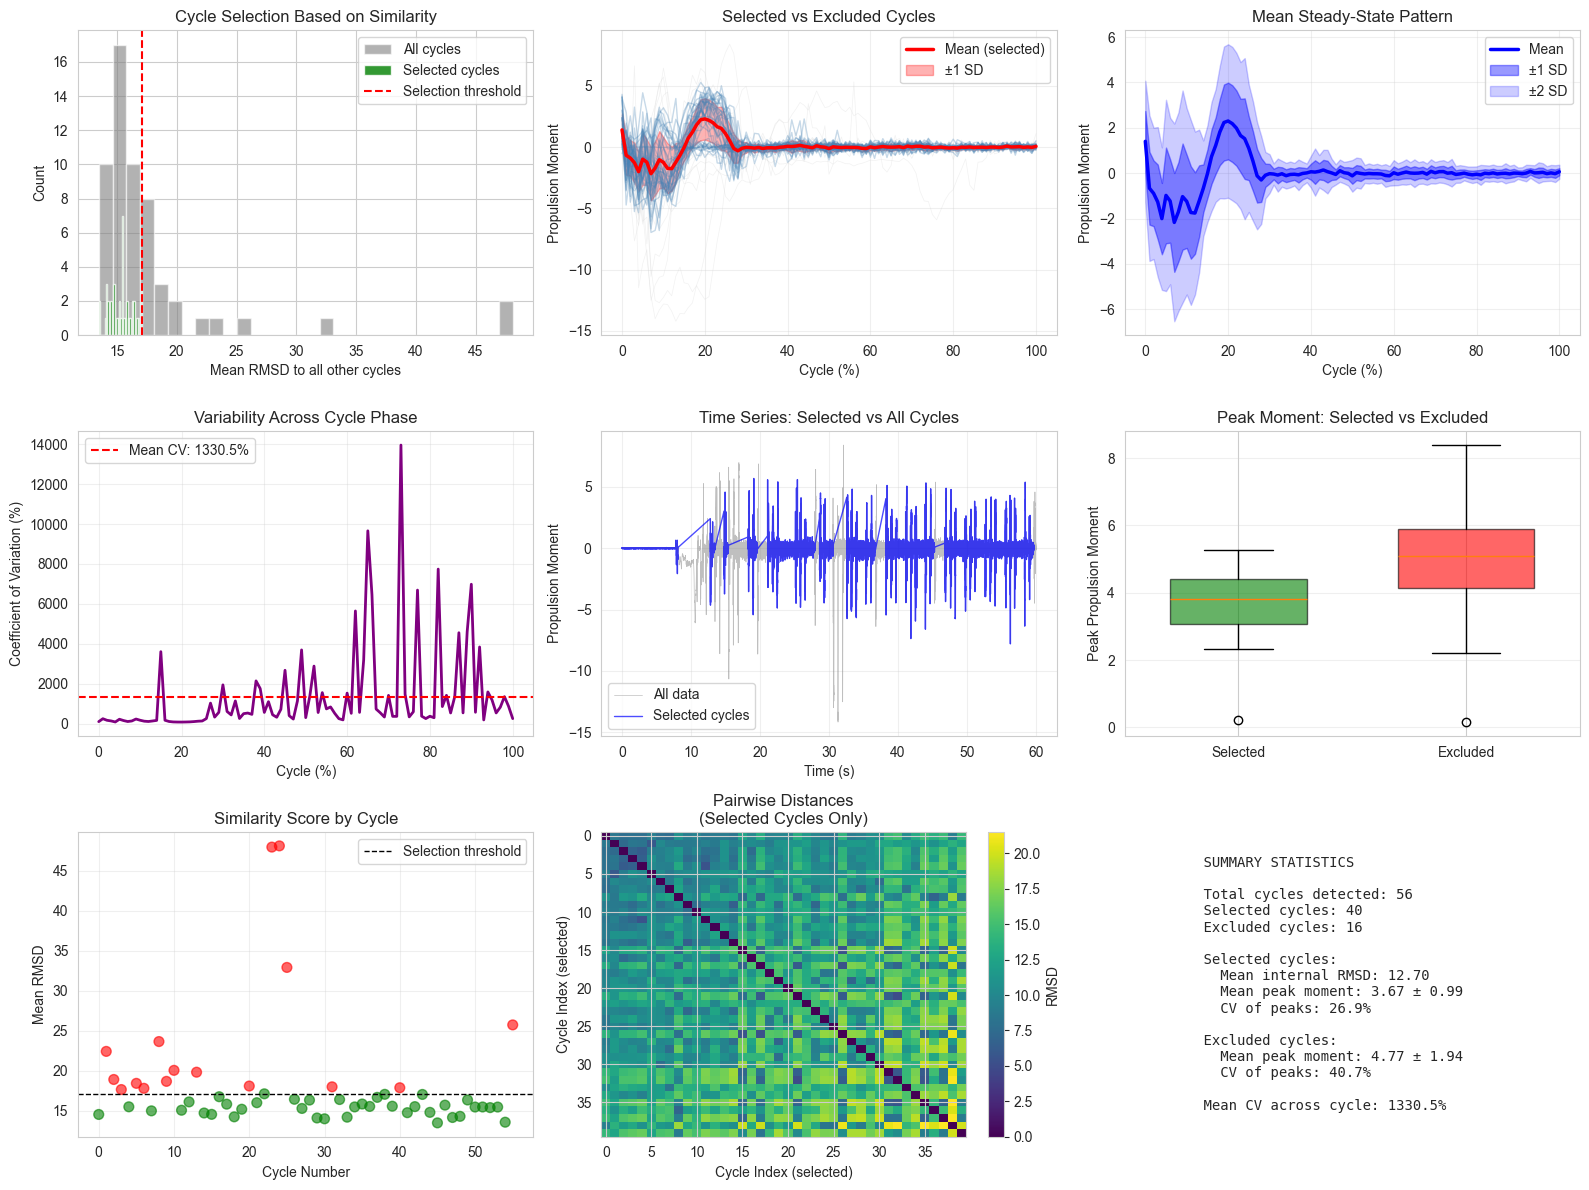

In [8]:
# Example with your column names

sub6Mx = df[df['time[sec]'] < 60]

results = find_steady_state_cycles(
    sub6Mx, 
    cycle_col='cycle[count]',  # replace with your cycle ID column
    time_col='time[sec]',    # replace with your time column
    moment_col='moment_z_total[Nm]', # replace with your propulsion moment column
    n_select=40
)

# Generate plots
fig1 = plot_cycle_selection_analysis(sub6Mx, results, 
                                     time_col='time[sec]', 
                                     moment_col='moment_z_total[Nm]',
                                     cycle_col='cycle[count]')
plt.show()


In [1]:
fig2 = plot_individual_cycles_grid(sub6Mx, results, 
                                   time_col='time[sec]', 
                                   moment_col='moment_z_total[Nm]',
                                   cycle_col='cycle[count]')
plt.show()

NameError: name 'plot_individual_cycles_grid' is not defined